In [1]:
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import cv2

In [2]:
# Constants
IMAGE_SIZE = 256
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-4
DATA_DIR = "/content/drive/MyDrive/PlantVillage"

# Configuration
USE_SELF_SUPERVISED = False  # Set True if limited labels
USE_BAYESIAN = True
USE_VIT = False  # Vision Transformer (set True to use)
USE_GRAD_CAM = True

In [3]:
# Load dataset
def load_dataset():
    train_ds = keras.preprocessing.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

    val_ds = keras.preprocessing.image_dataset_from_directory(
        DATA_DIR,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=(IMAGE_SIZE, IMAGE_SIZE),
        batch_size=BATCH_SIZE
    )

    class_names = train_ds.class_names
    return train_ds, val_ds, class_names

train_ds, val_ds, class_names = load_dataset()
num_classes = len(class_names)

Found 2152 files belonging to 3 classes.
Using 1722 files for training.
Found 2152 files belonging to 3 classes.
Using 430 files for validation.


In [4]:
# Data augmentation
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
])

In [5]:
# Self-supervised pretraining (SimCLR-like)
if USE_SELF_SUPERVISED:
    ssl_model = keras.Sequential([
        layers.Rescaling(1./255),
        data_augmentation,
        layers.Conv2D(64, 3, activation='relu'),
        layers.MaxPooling2D(),
        layers.Conv2D(128, 3, activation='relu'),
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu')
    ])

    # Train SSL model (pseudo-code - would need contrastive loss implementation)
    # ssl_model.compile(...)
    # ssl_model.fit(unlabeled_data, ...)

In [6]:
# Bayesian layers
def bayesian_layer(x, units, activation='relu'):
    return tfp.layers.DenseFlipout(
        units,
        kernel_prior_fn=tfp.layers.default_multivariate_normal_fn,
        kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
        activation=activation
    )(x)

In [7]:
# Vision Transformer implementation (TensorFlow native)
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super().__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        return tf.reshape(patches, [batch_size, -1, patches.shape[-1]])

class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super().__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

def build_vit():
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)

    # Create patches
    patch_size = 32
    num_patches = (IMAGE_SIZE // patch_size) ** 2
    projection_dim = 64

    patches = Patches(patch_size)(x)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Transformer blocks
    for _ in range(4):  # Reduced number of blocks for efficiency
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Multi-head attention
        attention_output = layers.MultiHeadAttention(
            num_heads=4, key_dim=projection_dim//4, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = layers.Dense(projection_dim * 2, activation="gelu")(x3)
        x3 = layers.Dropout(0.1)(x3)
        x3 = layers.Dense(projection_dim, activation="gelu")(x3)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Final processing
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    return keras.Model(inputs, representation)

In [8]:
# Model builder
def build_model():
    inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))
    x = layers.Rescaling(1./255)(inputs)
    x = data_augmentation(x)

    if USE_VIT:  # Our new TensorFlow-native ViT
        vit_model = build_vit()
        x = vit_model(x)
    else:  # ResNet with Bayesian option
        base_model = keras.applications.ResNet50(
            weights='imagenet',
            include_top=False,
            input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
        )
        base_model.trainable = True
        x = base_model(x)
        x = layers.GlobalAveragePooling2D()(x)

    if USE_BAYESIAN:
        # Create a custom layer wrapper for Bayesian operations
        class BayesianDenseWrapper(layers.Layer):
            def __init__(self, units, activation=None):
                super().__init__()
                self.units = units
                self.activation = activation
                self.bayesian_layer = tfp.layers.DenseFlipout(
                    units,
                    kernel_prior_fn=tfp.layers.default_multivariate_normal_fn,
                    kernel_posterior_fn=tfp.layers.default_mean_field_normal_fn(is_singular=False),
                    activation=activation
                )

            def call(self, inputs):
                return self.bayesian_layer(inputs)

        # Use the wrapper instead of direct tfp.layers
        x = BayesianDenseWrapper(256, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = BayesianDenseWrapper(num_classes, activation='softmax')(x)
    else:
        x = layers.Dense(256, activation='relu')(x)
        x = layers.Dropout(0.5)(x)
        outputs = layers.Dense(num_classes, activation='softmax')(x)

    return keras.Model(inputs, outputs)

In [9]:
# Build and compile model
model = build_model()
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/layers/util.py:99: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  loc = add_variable_fn(
/usr/local/lib/python3.11/dist-packages/tensorflow_probability/python/layers/util.py:109: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  untransformed_scale = add_variable_fn(
/usr/local/lib/python3.11/dist-packages/tf_keras/src/initializers/initializers.py:121: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(


In [10]:
# Training
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks = [
        keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True),
        keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3),
        keras.callbacks.ModelCheckpoint(
            'best_model.keras',  # Use new Keras format
            save_best_only=True,
            monitor='val_loss'
        )
    ]
)

Epoch 1/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 366s 6s/step - accuracy: 0.6775 - loss: 1.5073 - val_accuracy: 0.4488 - val_loss: 10.2851 - learning_rate: 1.0000e-04
Epoch 2/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 36s 666ms/step - accuracy: 0.9565 - loss: 0.1713 - val_accuracy: 0.4256 - val_loss: 15.3988 - learning_rate: 1.0000e-04
Epoch 3/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 43s 706ms/step - accuracy: 0.9723 - loss: 0.1184 - val_accuracy: 0.3233 - val_loss: 6.4882 - learning_rate: 1.0000e-04
Epoch 4/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 703ms/step - accuracy: 0.9843 - loss: 0.0703 - val_accuracy: 0.1977 - val_loss: 6.1198 - learning_rate: 1.0000e-04
Epoch 5/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 40s 686ms/step - accuracy: 0.9819 - loss: 0.0457 - val_accuracy: 0.1698 - val_loss: 9.1276 - learning_rate: 1.0000e-04
Epoch 6/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 686ms/step - accuracy: 0.9896 - loss: 0.0421 - val_accuracy: 0.4512 - val_loss: 9.8034 - learning_rate: 1.0000e-04
Epoch 7/30
54/54 ━━━━━━━━━━━━━━━━━━━━ 41s 679ms/step - acc

In [18]:
def flawless_gradcam(model, img_array):
    """Completely debugged Grad-CAM implementation"""
    # Get the ResNet50 base model
    resnet = model.get_layer('resnet50')

    # Create model that outputs both last conv layer and predictions
    grad_model = keras.models.Model(
        inputs=model.inputs,
        outputs=[
            resnet.get_layer('conv5_block3_out').output,
            model.output
        ]
    )

    # Compute gradients
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array, training=False)
        pred_index = tf.argmax(predictions[0])
        loss = predictions[:, pred_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Generate heatmap
    conv_outputs = conv_outputs[a]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)

    return heatmap.numpy()

Starting visualization test...

Sample 1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
True: Potato___Late_blight | Predicted: Potato___Late_blight
Confidence: 81.04000091552734%


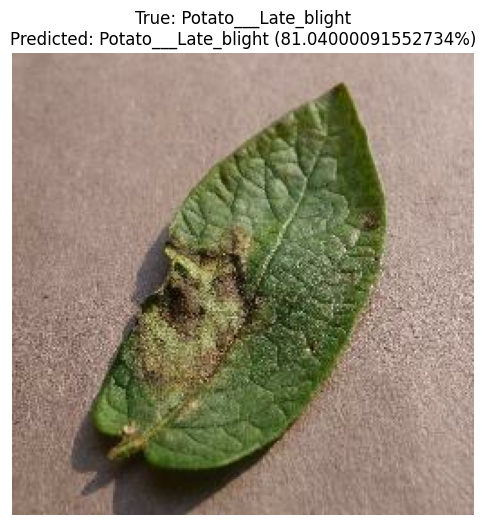


Sample 2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
True: Potato___Late_blight | Predicted: Potato___Late_blight
Confidence: 100.0%


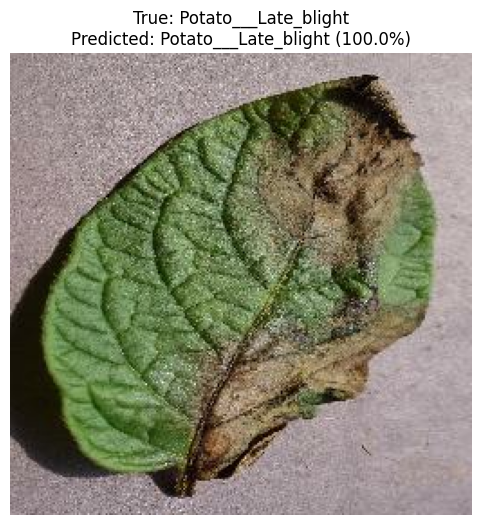


Sample 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
True: Potato___Late_blight | Predicted: Potato___healthy
Confidence: 98.04000091552734%


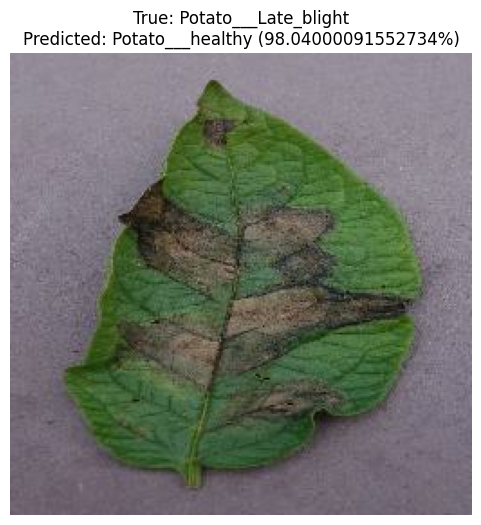

In [19]:
def perfect_visualization(sample_index=0):
    """Completely debugged visualization function"""
    # Get validation sample
    for images, labels in val_ds.take(1):
        img = images[sample_index]
        true_label = labels[sample_index].numpy()

    true_class = class_names[true_label]

    # Preprocess through all layers
    x = tf.expand_dims(img, axis=0)
    x = model.layers[1](x)  # Rescaling
    x = model.layers[2](x)  # Augmentation

    # Get prediction
    pred = model.predict(x)
    pred_class = class_names[np.argmax(pred[0])]
    confidence = round(100 * np.max(pred[0]), 2)

    print(f"True: {true_class} | Predicted: {pred_class}")
    print(f"Confidence: {confidence}%")

    # Generate Grad-CAM
    try:
        heatmap = flawless_gradcam(model, x)
        heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

        # Create visualization
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

        # Original image
        ax1.imshow(img.numpy().astype("uint8"))
        ax1.set_title(f"True: {true_class}")
        ax1.axis('off')

        # Heatmap
        ax2.imshow(heatmap, cmap='jet')
        ax2.set_title("Disease Attention Map")
        ax2.axis('off')

        # Overlay
        ax3.imshow(img.numpy().astype("uint8"))
        ax3.imshow(heatmap, alpha=0.4, cmap='jet')
        ax3.set_title(f"Predicted: {pred_class}\nConfidence: {confidence}%")
        ax3.axis('off')

        plt.tight_layout()
        plt.show()

    except Exception as e:
        plt.figure(figsize=(6, 6))
        plt.imshow(img.numpy().astype("uint8"))
        plt.title(f"True: {true_class}\nPredicted: {pred_class} ({confidence}%)")
        plt.axis('off')
        plt.show()

# Test with first 3 samples
print("Starting visualization test...")
for i in range(3):
    print(f"\n{'='*50}\nSample {i+1}")
    perfect_visualization(sample_index=i)  # Pass as keyword argument

In [14]:
# Save final model
FINAL_MODEL_PATH = "potato_disease_final_model.h5"
model.save(FINAL_MODEL_PATH)
print(f"Model saved to {FINAL_MODEL_PATH}")

Model saved to potato_disease_final_model.h5
